In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [24]:
# We are defining our  M(t), C(t), F(t)

def misinformation(t):
    # Simple example: spike between day 20 and 40
    if 20 <= t <= 40:
        return 0.5  
    else:
        return 0.1

def campaign(t):
    # Positive outreach between day 10 and 25
    if 10 <= t <= 25:
        return 0.4  
    else:
        return 0.0

def false_belief(t):
    # Slowly increasing resistance over time
    return min(0.05 + 0.002*t, 0.6)


In [26]:
def seirv_behavior(t, y, params):
    S, E, I, R, V, w = y
    beta, sigma, gamma, kappa, v_base, a1, a2, a3, a4, N = params
    
    # Score from social behavior model
    score = (a1 * I/N) - (a2 * misinformation(t)) + (a3 * campaign(t)) - (a4 * false_belief(t))
    
    # ODEs
    dSdt = -beta * S * I / N - v_base * w * S
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    dVdt = v_base * w * S
    dwdt = kappa * w * (1 - w) * score
    
    return [dSdt, dEdt, dIdt, dRdt, dVdt, dwdt]


In [27]:
# Population
N = 10**6

# Initial conditions
I0 = 500
E0 = 100
R0 = 0
V0 = 0
S0 = N - I0 - E0 - R0 - V0
w0 = 0.4  # Initial willingness

y0 = [S0, E0, I0, R0, V0, w0]

# Parameters
beta = 0.4      # Transmission rate
sigma = 1/5     # Incubation period: 5 days
gamma = 1/10    # Recovery period: 10 days
kappa = 0.5     # Behavior update speed
v_base = 0.022  # Baseline vaccination rate

# Weights: tune these!
a1, a2, a3, a4 = 2, 5, 5, 4

params = [beta, sigma, gamma, kappa, v_base, a1, a2, a3, a4, N]


In [28]:
# Time span
t_span = (0, 180)
t_eval = np.linspace(*t_span, 181)

solution = solve_ivp(seirv_behavior, t_span, y0, args=(params,), t_eval=t_eval)
S, E, I, R, V, w = solution.y


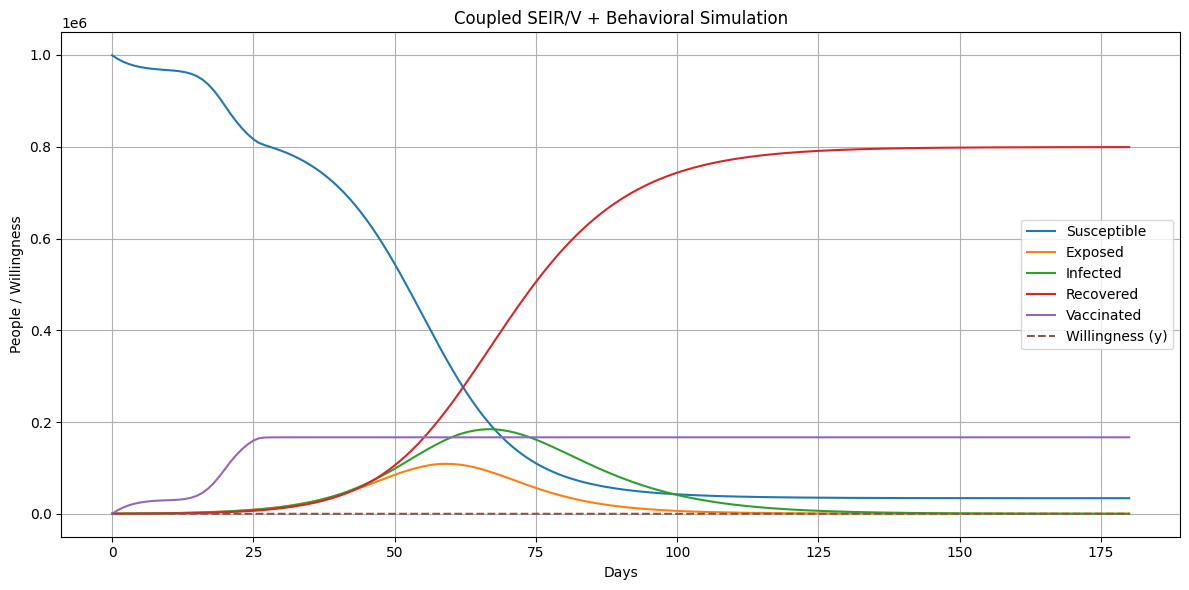

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(t_eval, S, label='Susceptible')
plt.plot(t_eval, E, label='Exposed')
plt.plot(t_eval, I, label='Infected')
plt.plot(t_eval, R, label='Recovered')
plt.plot(t_eval, V, label='Vaccinated')
plt.plot(t_eval, w, label='Willingness (y)', linestyle='--')
plt.xlabel("Days")
plt.ylabel("People / Willingness")
plt.title("Coupled SEIR/V + Behavioral Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


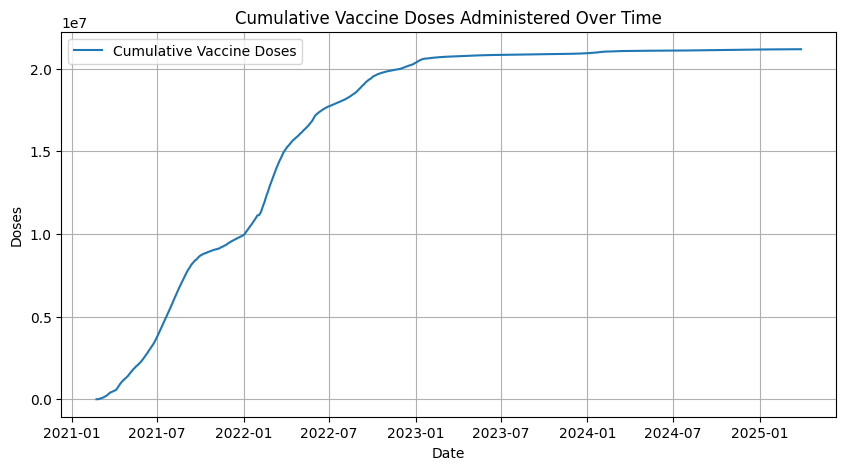

In [ ]:
df_vax = pd.read_csv('Data/vaccination-rates-over-time-by-age.csv')
df_vax['Date'] = pd.to_datetime(df_vax['Date'], dayfirst=True)

df_vax_daily = df_vax.groupby('Date').sum(numeric_only=True)

df_vax_daily['Total Doses'] = df_vax_daily.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(df_vax_daily.index, df_vax_daily['Total Doses'].cumsum(), label='Cumulative Vaccine Doses')
plt.title("Cumulative Vaccine Doses Administered Over Time")
plt.xlabel("Date")
plt.ylabel("Doses")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from ipywidgets import interact, FloatSlider

def interactive_sim(a1=10, a2=5, a3=5, a4=5, v_base=0.002, kappa=0.5):
    sim_params = [beta, sigma, gamma, kappa, v_base, a1, a2, a3, a4, N]
    
    sol = solve_ivp(seirv_behavior, t_span, y0, args=(sim_params,), t_eval=t_eval)
    S, E, I, R, V, w = sol.y

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(t_eval, I, label="Infected")
    plt.plot(t_eval, V, label="Vaccinated")
    plt.plot(t_eval, w, label="Willingness (y)", linestyle="--")
    plt.title("Interactive Simulation")
    plt.xlabel("Days")
    plt.ylabel("Population / Willingness")
    plt.legend()
    plt.grid(True)
    plt.show()

interact(
    interactive_sim,
    a1=FloatSlider(min=0, max=15, step=1, value=10, description="Infection Awareness (a1)"),
    a2=FloatSlider(min=0, max=15, step=1, value=5, description="Misinformation (a2)"),
    a3=FloatSlider(min=0, max=15, step=1, value=5, description="Campaign Influence (a3)"),
    a4=FloatSlider(min=0, max=15, step=1, value=5, description="False Beliefs (a4)"),
    v_base=FloatSlider(min=0.0005, max=0.01, step=0.0005, value=0.002, description="Base Vax Rate"),
    kappa=FloatSlider(min=0.1, max=1.5, step=0.1, value=0.5, description="Behavior Learning (kappa)")
)


In [50]:

combinations = [
    (10, 5, 5, 5),
    (10, 9, 3, 4),
    (6, 4, 8, 3),
    (8, 8, 4, 7),
]
N = 1_000_000
I0, E0, R0, V0, w0 = 500, 100, 0, 0, 0.4
S0 = N - I0 - E0 - R0 - V0
y0 = [S0, E0, I0, R0, V0, w0]
t_span = (0, 180)
t_eval = np.linspace(*t_span, 181)
beta, sigma, gamma = 0.4, 1/5, 1/10
kappa = 0.5
v_base = 0.002

for a1, a2, a3, a4 in combinations:
    label = f"{a1}_{a2}_{a3}_{a4}"
    params = [beta, sigma, gamma, kappa, v_base, a1, a2, a3, a4, N]
    
    sol = solve_ivp(seirv_behavior, t_span, y0, args=(params,), t_eval=t_eval)

    if not sol.success:
        print(f"Integration failed for {label}: {sol.message}")
        continue

    if sol.y.shape[1] != len(t_eval):
        print(f"Shape mismatch for {label}: sol.y.shape={sol.y.shape}, len(t_eval)={len(t_eval)}")
        continue

    S, E, I, R, V, w = sol.y

    df = pd.DataFrame({
        "Day": t_eval,
        "Susceptible": S,
        "Exposed": E,
        "Infected": I,
        "Recovered": R,
        "Vaccinated": V,
        "Willingness": w
    })

    df.to_csv(f"{label}.csv", index=False)
    print(f"Saved {label}.csv")


Saved 10_5_5_5.csv
Saved 10_9_3_4.csv
Integration failed for 6_4_8_3: Required step size is less than spacing between numbers.
Saved 8_8_4_7.csv


In [57]:
combinations = []
for i in range(0,15):
    for j in range(0,15):
                combinations.append((i,j,i,j))    


print(len(combinations))

225


In [58]:
N = 1_000_000
I0, E0, R0, V0, w0 = 500, 100, 0, 0, 0.4
S0 = N - I0 - E0 - R0 - V0
y0 = [S0, E0, I0, R0, V0, w0]
t_span = (0, 180)
t_eval = np.linspace(*t_span, 181)
beta, sigma, gamma = 0.4, 1/5, 1/10
kappa = 0.5
v_base = 0.002

for a1, a2, a3, a4 in combinations:
    label = f"{a1}_{a2}_{a3}_{a4}"
    params = [beta, sigma, gamma, kappa, v_base, a1, a2, a3, a4, N]
    
    sol = solve_ivp(seirv_behavior, t_span, y0, args=(params,), t_eval=t_eval)

    if not sol.success:
        print(f"Integration failed for {label}: {sol.message}")
        continue

    if sol.y.shape[1] != len(t_eval):
        print(f"Shape mismatch for {label}: sol.y.shape={sol.y.shape}, len(t_eval)={len(t_eval)}")
        continue

    S, E, I, R, V, w = sol.y

    df = pd.DataFrame({
        "Day": t_eval,
        "Susceptible": S,
        "Exposed": E,
        "Infected": I,
        "Recovered": R,
        "Vaccinated": V,
        "Willingness": w
    })

    df.to_csv(f"{label}.csv", index=False)
    print(f"Saved {label}.csv")


Saved 0_0_0_0.csv
Saved 0_1_0_1.csv
Saved 0_2_0_2.csv
Saved 0_3_0_3.csv
Saved 0_4_0_4.csv
Saved 0_5_0_5.csv
Saved 0_6_0_6.csv
Saved 0_7_0_7.csv
Saved 0_8_0_8.csv
Saved 0_9_0_9.csv
Saved 0_10_0_10.csv
Saved 0_11_0_11.csv
Saved 0_12_0_12.csv
Saved 0_13_0_13.csv
Saved 0_14_0_14.csv
Saved 1_0_1_0.csv
Saved 1_1_1_1.csv
Saved 1_2_1_2.csv
Saved 1_3_1_3.csv
Saved 1_4_1_4.csv
Saved 1_5_1_5.csv
Saved 1_6_1_6.csv
Saved 1_7_1_7.csv
Saved 1_8_1_8.csv
Saved 1_9_1_9.csv
Saved 1_10_1_10.csv
Saved 1_11_1_11.csv
Saved 1_12_1_12.csv
Saved 1_13_1_13.csv
Saved 1_14_1_14.csv
Saved 2_0_2_0.csv
Saved 2_1_2_1.csv
Saved 2_2_2_2.csv
Saved 2_3_2_3.csv
Saved 2_4_2_4.csv
Saved 2_5_2_5.csv
Saved 2_6_2_6.csv
Saved 2_7_2_7.csv
Saved 2_8_2_8.csv
Saved 2_9_2_9.csv
Saved 2_10_2_10.csv
Saved 2_11_2_11.csv
Saved 2_12_2_12.csv
Saved 2_13_2_13.csv
Saved 2_14_2_14.csv
Saved 3_0_3_0.csv
Saved 3_1_3_1.csv
Saved 3_2_3_2.csv
Saved 3_3_3_3.csv
Saved 3_4_3_4.csv
Saved 3_5_3_5.csv
Saved 3_6_3_6.csv
Saved 3_7_3_7.csv
Saved 3_8_3_8.cs